# Testing VLM1

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv
import json
import torch

from transformers import AutoProcessor, AutoModelForVision2Seq
from time import sleep
from tqdm import trange
from scripts.dataset import Dataset

print(f"Cuda is available: {torch.cuda.is_available()}")
sns.set_theme(palette=sns.color_palette("rocket_r"))

Cuda is available: True


In [37]:
assert os.path.isfile("kaggle.json"), "Kaggle credentials are required to run this project."

credentials = None
with open("kaggle.json") as kaggle_json:
    credentials = json.load(kaggle_json)

print(f"Using credentials = {credentials}")
os.environ['KAGGLE_USERNAME'] = credentials["username"]
os.environ['KAGGLE_KEY'] = credentials["key"]

Using credentials = {'username': 'gabrieldossantoslima', 'key': '5558e50b69ffd77b038222e93f258941'}


In [ ]:
CURRENT_PATH = os.getcwd()

DATASET_PATH = os.path.join(CURRENT_PATH, "dataset.csv")
EXPERIMENT_PATH = os.path.join(CURRENT_PATH, '__experiments__')
EXPERIMENT_NAME = "llm_model"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Trainig Parameters
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNEL = 3

# LLM Prediction
CHECKPOINT_PATH = os.path.join(CURRENT_PATH, "report-gemma3-270m.csv")

In [39]:
assert os.path.isfile(DATASET_PATH), "Dataset not exists. Please run the previous notebook."
test_dataset = Dataset(dataset_path=DATASET_PATH, dataset_mode="csv", partition_name="test", preload=True, shuffle=False)

[LOG] Importing data from c:\Users\limag\projects\si\vlm_garbage_classification\dataset.csv, mode = csv
[LOG] Filtered by partition = test
[LOG] Preloading the dataset


100%|██████████| 506/506 [00:00<00:00, 1125.79it/s]


In [40]:
def as_numpy(dataset: Dataset):
    n = len(dataset)
    iterator = iter(dataset)
    x = np.ndarray(shape=(n, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), dtype=np.float64)
    y = np.ndarray(shape=(n,), dtype=np.int8)
    names = np.ndarray(shape=(n,), dtype=object)
    for index in trange(n):
        xi, yi, image_name = next(iterator)
        xi = cv.resize(xi, [IMAGE_WIDTH, IMAGE_HEIGHT])
        x[index] = xi
        y[index] = yi
        names[index] = image_name
    return x, y, names

x_test, y_test, names = as_numpy(test_dataset)
print(f"Image Shape = {x_test[0].shape}")

100%|██████████| 506/506 [00:00<00:00, 2087.24it/s]

Image Shape = (224, 224, 3)


## Preparing the LLM

In [41]:
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                torch_dtype=torch.bfloat16,
                                                _attn_implementation="eager").to(DEVICE)

c:\Users\limag\.conda\envs\deep_learning\lib\site-packages\transformers\models\auto\modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>
<row_4_col_1><row_4_col_2><row_4_col_3><row_4_col_4>

<global-img>Is this a image of glass, cardboard, plastic, metal, trash, paper?
Assistant: Plastic.
plastic
plastic


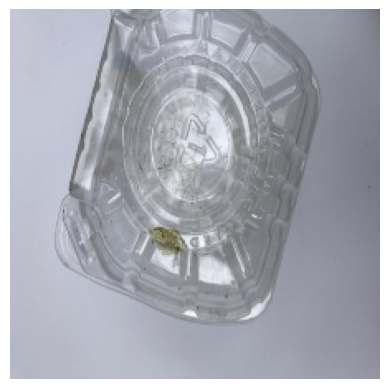

In [ ]:
def get_zeroshot_classification(prompt: str):
    prompt = prompt.split("Assistant:")[-1]
    for class_name in test_dataset.classes:
        if class_name in prompt.lower():
            return test_dataset.encode_label(class_name)
    return 0

def generate_zeroshot_prompt(x: np.array):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Is this a image of glass, cardboard, plastic, metal, trash, paper?"}
            ]
        },
    ]

    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[x], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts[0]

In [ ]:
assert not os.path.isfile(CHECKPOINT_PATH), f"{CHECKPOINT_PATH} already exists."

y_pred = np.ndarray(shape=y_test.shape, dtype=np.int8)
checkpoint = {
    "image_name": [],
    "y_true": [],
    "y_pred": [],
    "y_true_as_str": [],
    "y_pred_as_str": [],
    "prompt": [],
}

# Iterate over the test dataset
for index in trange(len(x_test)):
    xi = x_test[index]
    yi = y_test[index]
    name = names[index]
    
    # Prediction...
    prompt = generate_zeroshot_prompt(xi)
    prediction = get_zeroshot_classification(prompt)
    
    # Saving results
    y_pred[index] = prediction
    
    # Saving checkpoint
    checkpoint["image_name"].append(name)
    checkpoint["y_true"].append(yi)
    checkpoint["y_pred"].append(prediction)
    checkpoint["y_true_as_str"].append(test_dataset.decode_label(yi))
    checkpoint["y_pred_as_str"].append(test_dataset.decode_label(prediction))
    pd.DataFrame.from_dict(checkpoint).to_csv(CHECKPOINT_PATH, sep=";", index=False)

## Evaluating the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from prettytable import PrettyTable

def plot_metrics(y_true: np.array, y_pred: np.array):
    table = PrettyTable(["Metric", "Value (%)"])
    
    # Calculating metrics...
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0.0) * 100

    table.add_row(['Accuracy', f"{accuracy:.2f}%"])
    table.add_row(['Precision', f"{precision:.2f}%"])
    table.add_row(['Recall', f"{recall:.2f}%"])
    table.add_row(['F1 Score', f"{f1:.2f}%"])
    
    print(table)

def plot_cm(y_true: np.array, y_pred: np.array):
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_true, y_pred)
    plt.title(f'Confusion Matrix')
    sns.heatmap(cm, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True), fmt='.0f', yticklabels=test_dataset.classes, xticklabels=test_dataset.classes)
    plt.show()

In [ ]:
plot_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

Visualizing some errors

In [ ]:
errors = []
for index in range(len(y_pred)):
    true = y_test[index] 
    pred = y_pred[index]
    if true != pred:
        errors.append((x_test[index], true, pred))

In [ ]:
nrows = 5
ncols = 4

figure, axis = plt.subplots(nrows, ncols, squeeze=False, figsize=(14,18))
figure.suptitle(f"Errors")
axes = []
for ax in axis:
    axes += [*ax]
for index in range(nrows * ncols):
    ax = axes[index]
    x, true_class, pred = errors[index]
    pred = test_dataset.decode_label(pred)
    true_class = test_dataset.decode_label(true_class)
    ax.axis("off")
    ax.set_title(f"[y_true={true_class}, y_pred={pred}]")
    ax.imshow(x.astype(np.int64))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()